# Analytical Modelling

Often, a well testing problem can be efficiently investigated using analytical solutions but these may require a degree of sophistication that is cumbersome for hand or Excel calculation.

The purpose of this notebook is to demonstrate a few Python techniques for well test modelling.

## 1. Implementing a Theis solution

Theis is the workhorse of pump test analysis in well-confined aquifers. It's reasonably easy to implement once you understand how to code up the well function, $W(u)$

\begin{equation}
W(u)=\int\limits_{u}^{\infty}\frac{1}{y}e^{-y}dy
\end{equation}

Fortunately, the exponential integral above is already implemented in `scipy`. The cell below implements the well function as the Python function `W(u)`.

In [2]:
from scipy.special import expi

def W(u): 
    return -expi(-u)

Run the cell below to see what the well function looks like. You can see where the logarithmic approximation is valid, for $u<0.05$.

Text(0, 0.5, '$W(u)$')

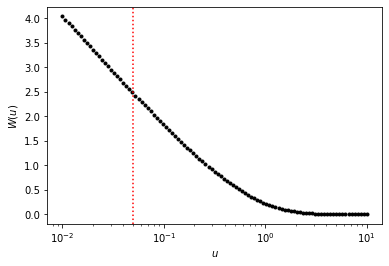

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
f,ax=plt.subplots(1,1)
u = np.logspace(-2,1,101)
ax.semilogx(u, W(u),'k.')
ax.axvline(0.05, color = 'r', linestyle=':')
ax.set_xlabel('$u$'); ax.set_ylabel('$W(u)$')

The `Theis` function is now straightforward to implement (run the cell below)

In [55]:
def Theis(r,t,Q,S,T): 
    return Q/(4*np.pi*T)*W(r**2*S/(4*T*t))

The function is already "vectorized", which means any of the inputs can be passed as a vector. The plot below gives drawdown 100 m from a well pumped at 20 L/s, in a formation with $T$=2200 m$^2$/d and $S$=10$^{-4}$.

Text(0, 0.5, 'drawdown [m]')

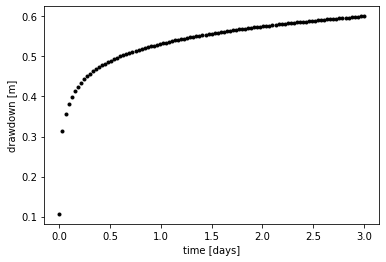

In [56]:
f,ax=plt.subplots(1,1)
t = np.linspace(0.001,3,101)
r,Q,S,T = [100., 20, 1.e-4, 2200]
ax.plot(t, Theis(r,t,Q*1.e-3*24*3600,S,T),'k.')
ax.set_xlabel('time [days]'); ax.set_ylabel('drawdown [m]')

***Why did we apply the scaling `Q*1.e-3*24*3600`?***

***Create a plot of drawdown over time inside a well of radius 0.3 m pumped at 2 m$^3$/min, $S$=0.2, $T$=200 m$^2$/s***

***Create a plot of drawdown with distance for the same parameters, at `t=0.1` and `t=1.5` days.***

In [57]:
# your code here

## 2. Superposition of elementary solutions

We can use superposition to:
1. Model the drawdown at a location due to multiple pumping wells.
2. Model the drawdown due a single well being pumped at different rates.

### 2.1 Multiple wells

Suppose we are monitoring an observation well that is:
1. 100 m from a well that has been pumping at 20 L/s for the last 3 days.
2. 50 m from a well that has been pumping at 30 L/s for only the last day.

What should the drawdown profile look like over time? (Assume the same aquifer parameters as the example in 1.)

Text(0, 0.5, 'drawdown [m]')

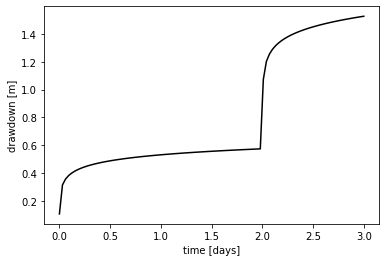

In [58]:
# APPROACH: create a time vector for the solution and use a loop to compute drawdown contributions from the individual wells
t = np.linspace(0.001,3,101)
h = 0.*t
S,T = [1.e-4, 2200]
r1,t1,Q1 = [100,0., 20]  # well 1 starts at t=0 (pumping for the last three days)
r2,t2,Q2 = [50, 2., 30]  # well 2 starts at t=2 (pumping for only the last day)

for i in range(len(t)):
    # contribution from well 1
    if t[i]>t1:
        h[i] = h[i] + Theis(r1, t[i]-t1, Q1*1.e-3*24*3600, S, T)
    # contribution from well 2
    if t[i]>t2:
        h[i] = h[i] + Theis(r2, t[i]-t2, Q2*1.e-3*24*3600, S, T)

f,ax=plt.subplots(1,1)
ax.plot(t, h,'k-')
ax.set_xlabel('time [days]'); ax.set_ylabel('drawdown [m]')

***Add a third well that has been pumping for 10 L/s for the last 2 days at a distance of 40 m from the observation well.***

In [59]:
# your code here

### 2.2 Step-rate pumping

Suppose we pump a well at:
1. 10 L/s for 30 mins, then
2. 15 L/s for another 30 mins.

What should the drawdown profile look like in the well, if the diameter is 0.7 m and there are no well losses?

In [60]:
# APPROACH: same as 2.1, except R1 = R2 = well radius and Q2 = size of pumping step.
# your code here

***Add a third pumping step, at 25 L/s for another 60 mins.***

***Pumping is halted and the well is allowed to recover. Model this as a negative pumping step of 25 L/s. Plot the recovery for the next 2 hours.***

## 3. Solving equations containing pumping solutions

Pumping solutions introduce all sorts of non-linearity and the potential for analytically non-invertible equations.

For example, suppose we are monitoring an observation bore. We have pumped a well 100 m away at 10 L/s for the last 30 mins and a second well 75 m away at 5 L/s for the last 60 mins. If the drawdown is 30 cm and the transmissivity is known to be 1650 m$^2$/d, what is the storativity, $S$?

Obviously, this is a complex (and contrived!) problem. Let's write out the superposition of Theis solutions

\begin{equation}
h = \underbrace{\frac{Q_1}{4\pi T}W\left(\frac{r_1^2S}{4T(t-t_1)}\right)}_{\text{first well}} + \underbrace{\frac{Q_2}{4\pi T}W\left(\frac{r_2^2S}{4T(t-t_2)}\right)}_{\text{second well}}
\end{equation}

Which with known quantities converted to metres and days, and then substituted is

\begin{equation}
0.3 = \frac{864}{4\pi\cdot 1650}W\left(\frac{100^2\cdot S}{4\cdot1650\cdot 0.021}\right) + \frac{432}{4\pi\cdot 1650}W\left(\frac{75^2\cdot S}{4\cdot1650\cdot0.042}\right)
\end{equation}

One way to solve for $S$ is by guess-and-check but that can take a while.

Another way is to use Python's root finding functions to solve the above equation in the form $LHS-RHS=0$.

In [61]:
from scipy.optimize import fsolve

# define the known parameters
h,r1,r2,Q1,Q2,t1,t2,T = [0.3,100,75,864,432,1./48,1./24,1650]

# define the root function for minimising, LHS - RHS, with the function input the unknown quantity
def f(S): 
    return h-Q1/(4*np.pi*T)*W(r1**2*S/(4*T*t1))-Q2/(4*np.pi*T)*W(r2**2*S/(4*T*t2))

# pass the FUNCTION HANDLE (name) and an initial guess [0.001] to the root function
S = fsolve(f,0.001)[0]
print("Storativity is", S)

Storativity is 9.752853715820548e-05


***Given the values $\beta$=10$^{-3}$ d/m$^2$, $r_w$=0.25 m, $S$=10$^{-4}$ and $t_{test}$=30 mins, use `fsolve` to show that the transmissivity in the equation below is $T$=1280 m$^2$/d.***

\begin{equation}
\beta = \frac{1}{4\pi T}W\left(\frac{r_w^2 S}{4Tt_{test}}\right)
\end{equation}

***For $h_{max}$=0.5 m, $\alpha$=1.e-13, $n$=3.5 and $t_{pump}$=1 year, use `fsolve` to show that the max. pumping rate in the equation below is $Q_{max}$=311 m$^3$/d.***

\begin{equation}
h_{max} = \frac{Q_{max}}{4\pi T}W\left(\frac{r_w^2 S}{4Tt_{pump}}\right)+\alpha Q_{max}^n
\end{equation}

In [62]:
# your code here

## (Extra) Fitting pumping solutions to data

We use pumping solutions to make sense of the data. One way to do this is the graphical method you learned in class.

A more general approach is to plot the data and a numerical model over top of each other. Then, make changes to the model parameters until a good match is achieved.

This can be done automatically with a Python function called `curve_fit`.

First, let's create some fake pumping data with *known* transmissivity $T$=1500 m$^2$/d and $S$=0.0034

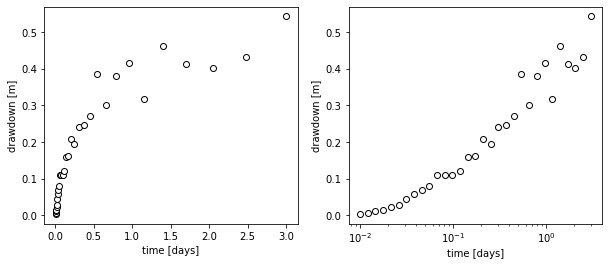

In [70]:
T,S = [1500,0.0034]
r,Q,tpump = [200., 25.*1.e-3*24*3600, 3.]    # 3 day test at 25 L/s, observed at 200 m
td = np.logspace(-2,np.log10(tpump), 31)      # 31 log-spaced measurements
hd = Theis(r,td,Q,S,T)                         # drawdown observations

hd = hd*(1.+0.1*np.random.randn(len(hd)))                 # add 10% normally distributed random noise - for a challenge

f,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(td,hd,'ko',mfc='w')
ax2.semilogx(td,hd,'ko',mfc='w')
for ax in [ax1,ax2]:ax.set_xlabel('time [days]');ax.set_ylabel('drawdown [m]')
    
# note, this is not the most accurate way to model pump test noise, it is for demonstration purposes only

Python `curve_fit` works by finding the parameters that minimize the sum-of-squares misfit between data and a model.

The 'model' must be expressed as a Python function, $f$, with a very particular input structure:
1. The first argument is the independent variable (time).
2. Subsequent arguments are parameters that `curve_fit` can play with ($T$ and $S$).
3. Any other parameters should be hard-coded.
4. The function must return the same thing measured by the data (drawdown).

See below for a function meeting this requirement.

In [74]:
def pump_test_model(t, T, S):
    # note how r and Q have been hard-coded - we know what these are
    return Theis(200., t, 25.*1.e-3*24*3600, S, T)

Now we call `curve_fit`, passing it the model (function handle/name), the data, and our starting guess at the model parameters.

In [78]:
from scipy.optimize import curve_fit
p,pcov = curve_fit(pump_test_model, td, hd, [1000, 1.e-2])
print('best-fit T =', p[0],'and S =', p[1])

best-fit T = 1495.7358957318952 and S = 0.0034192470900673037


The first output is a vector of the estimated parameters. We'll use it to plot the 'best' model over the data.

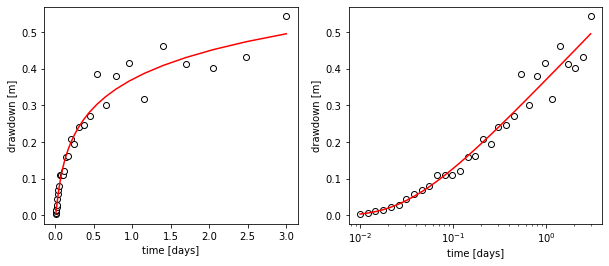

In [76]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(td,hd,'ko',mfc='w')
ax1.plot(t,pump_test_model(t, p[0], p[1]),'r-')
ax2.semilogx(td,hd,'ko',mfc='w')
ax2.semilogx(t,pump_test_model(t, p[0], p[1]),'r-')
for ax in [ax1,ax2]:ax.set_xlabel('time [days]');ax.set_ylabel('drawdown [m]')

## (Extra) Uncertainty of best-fit pumping solutions

If we are not precisely certain of the data, then it can be possible for more than one model to provide a credible fit to the data. 

There are numerous ways to handle model uncertainty (and the best way depends on where the error is coming from - are the data noisy or is the conceptual model wrong?)

A simple way to get a first cut at model uncertainty is called Linear Sensitivity Analysis. `curve_fit` returns a second output called the covariance matrix, which gives some indication about how confident it is estimating the values of $T$ and $S$. 

We can use the covariance matrix to generate "possible pairs" of $[T,S]$ and plot these models.

We can also use ranges of the sampled parameters to construct uncertainty estimates. In this case, we estimate transmissivity to be between 1375 and 1635 m$^2$/d with 90% confidence (in fact, it is 1500 m$^2$/d), and storativity between 2.8 and 4.0e-3 (in fact, it is 3.4e-3).

covariance matrix is [[ 7.39167657e+03 -2.71649918e-02]
 [-2.71649918e-02  1.44047134e-07]]
5 to 95-percentile range of T is [1374.13,1635.84]
5 to 95-percentile range of S is [2.75e-03,3.96e-03]


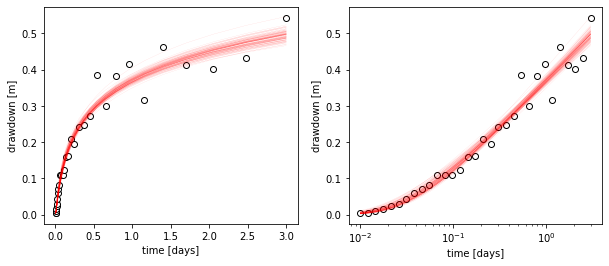

In [83]:
from scipy.optimize import curve_fit
p,pcov = curve_fit(pump_test_model, td, hd, [1000, 1.e-2])
print('covariance matrix is', pcov)

f,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(td,hd,'ko',mfc='w')
ax2.semilogx(td,hd,'ko',mfc='w')

N = 100   # number of possible pairs to generate
Ts = []; Ss = []
for p in np.random.multivariate_normal(p, pcov, N):
    ax1.plot(t,pump_test_model(t, *p),'r-', lw=0.2, alpha=0.2)
    ax2.semilogx(t,pump_test_model(t, *p),'r-', lw=0.2, alpha=0.2)
    Ts.append(p[0]); Ss.append(p[1])
    
for ax in [ax1,ax2]:ax.set_xlabel('time [days]');ax.set_ylabel('drawdown [m]')
    
print('5 to 95-percentile range of T is [{:3.2f},{:3.2f}]'.format(*np.percentile(Ts,[5,95])))
print('5 to 95-percentile range of S is [{:3.2e},{:3.2e}]'.format(*np.percentile(Ss,[5,95])))
    